# Handlers

Esta tabla contiene la información adicional de las sentencias Try/TryStar. --> ABEL COMPLETAR <--

## 1 - Obtencion de datos

In [1]:
import matplotlib.pyplot as plt
from notebooks_utils import *

full_table = get_data('handlers')

# Table name, features and target.
TABLE_NAME = 'handlers'
TABLE_FEATURES = ['handler__number_of_handlers', 'handler__has_star', 'handler__has_finally', 'handler__has_catch_all', 'handler__average_body_count', 'handler__expertise_level']
TABLE_TARGET = 'handler__expertise_level'

# Load features and target.
X, y = full_table[TABLE_FEATURES], full_table[[TABLE_TARGET]].iloc[:,0]

# Print information about the loaded table.
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

print(f'As we can see the downloaded data contains a total of {X.shape[0]} instances. For each instance we have {X.shape[1]} attributes.')

2024-05-24 13:11:28.513184 Data cache files found ...
2024-05-24 13:11:28.515189 Data cache files successfully loaded!!
Features shape: (10803, 6)
Target shape: (10803,)
As we can see the downloaded data contains a total of 10803 instances. For each instance we have 6 attributes.


## 2 - Exploracion de datos

Una vez tenemos nuestra tabla en un dataframe el siguiente paso es explorarla para ver qué tipo de información contiene.

In [2]:
print(X.info())
print('=============')
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10803 entries, 0 to 10802
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   handler__number_of_handlers  10803 non-null  int64  
 1   handler__has_star            10803 non-null  bool   
 2   handler__has_finally         10803 non-null  bool   
 3   handler__has_catch_all       10803 non-null  bool   
 4   handler__average_body_count  10803 non-null  float64
 5   handler__expertise_level     10803 non-null  object 
dtypes: bool(3), float64(1), int64(1), object(1)
memory usage: 285.0+ KB
None
<class 'pandas.core.series.Series'>
RangeIndex: 10803 entries, 0 to 10802
Series name: handler__expertise_level
Non-Null Count  Dtype 
--------------  ----- 
10803 non-null  object
dtypes: object(1)
memory usage: 84.5+ KB
None


Cómo podemos ver la tabla está compuesta por 2 variables numéricas, 3 de tipo boleano  y una de tipo objeto.

### 2.1 - Balance de clases

In [3]:
instances_for_class_low = len(full_table[full_table[TABLE_TARGET] == "BEGINNER"])
instances_for_class_high = len(full_table[full_table[TABLE_TARGET] == "EXPERT"])

print(f"The dataset contains {instances_for_class_low/len(full_table)*100:.4}% instances for BEGINNER class and {instances_for_class_high/len(full_table)*100:.4}% for EXPERT class.")

The dataset contains 82.88% instances for BEGINNER class and 17.12% for EXPERT class.


### 2.2 - Duplicados
Miramos si la tabla tiene entradas duplicadas.

In [4]:
number_of_duplicated_entries = sum(full_table.duplicated(subset=TABLE_FEATURES + [TABLE_TARGET]))
duplicated_entries_pct = number_of_duplicated_entries / len(full_table) * 100
print(f"The dataset contains [{duplicated_entries_pct:.4}%] of duplicated entries.")

The dataset contains [99.07%] of duplicated entries.


### 2.3 - Valores Nulos 
Miramos si alguna de las variables que contiene la tabla contiene algún valor que sea nulo.

In [5]:
X.isnull().sum()

handler__number_of_handlers    0
handler__has_star              0
handler__has_finally           0
handler__has_catch_all         0
handler__average_body_count    0
handler__expertise_level       0
dtype: int64

Aunque una columna no contenga valores nulos podría ser que contenga valores vacíos. Si los hubiese la siguiente función los mostraría.

In [6]:
print_empty_cols(X)

handler__number_of_handlers
---------------------------
0 instancias no tienen un valor para la columna handler__number_of_handlers


handler__has_star
-----------------
0 instancias no tienen un valor para la columna handler__has_star


handler__has_finally
--------------------
0 instancias no tienen un valor para la columna handler__has_finally


handler__has_catch_all
----------------------
0 instancias no tienen un valor para la columna handler__has_catch_all


handler__average_body_count
---------------------------
0 instancias no tienen un valor para la columna handler__average_body_count


handler__expertise_level
------------------------
0 instancias no tienen un valor para la columna handler__expertise_level




### 2.4 - Describimos los valores de las variables de la tabla.

In [7]:
np.transpose(X.describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
handler__number_of_handlers,10803.0,NaN,NaN,NaN,0.993891,0.500657,0.0,1.0,1.0,1.0,9.0
handler__has_star,10803,1,False,10803,NaN,NaN,NaN,NaN,NaN,NaN,NaN
handler__has_finally,10803,2,False,9818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
handler__has_catch_all,10803,2,False,10139,NaN,NaN,NaN,NaN,NaN,NaN,NaN
handler__average_body_count,10803.0,NaN,NaN,NaN,1.259407,0.843251,0.0,1.0,1.0,1.0,11.0
handler__expertise_level,10803,2,BEGINNER,8953,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### IMPORTANTE
Hay try con un numero medio de sentencias en los bodies de 0? Un try vacio? La indentacion de python suele impedirlo

Vamos a discretizar las variables numericas, agrupando conjuntos de valores en categorias, para hacer un análisis de los datos. Para cada variable es necesaario ver la distribucion de lo valores para hacer los bins (categorias).

In [8]:
# DISCRETIZATION
X_copy = X.copy()

discretized_columns = {
    "handler__number_of_handlers": [(0.0, 0.0), (1.0, 1.0), (1.0, inf)],  # min: 0.0 max: 9.0 
    "handler__average_body_count": [(0.0, 1.0), (1.0, 2.0), (2.0, inf)],  # min: 0.0 max: 11.0 
}

discretize_columns(X_copy, discretized_columns)
    
# SINGLE FEATURE
print("--- SINGLE FEATURE ---")
print(get_statistics(X_copy, ['handler__number_of_handlers'], 10))
print(get_statistics(X_copy, ['handler__average_body_count'], 10))
print(get_statistics(X_copy, ['handler__has_star'], 10))
print(get_statistics(X_copy, ['handler__has_finally'], 10))
print(get_statistics(X_copy, ['handler__has_catch_all'], 10))

# 2 FEATURES
print("--- TWO FEATURES ---")
#print(get_statistics(X_copy, ['import__average_imported_modules', 'import__module_imports_pct'], 10))

# 3 FEATURES
print("--- THREE FEATURES ---")
#print(get_statistics(X_copy, ['program__has_sub_dirs_with_code', 'program__has_packages', 'program__has_code_root_package'], 10))

--- SINGLE FEATURE ---
handler__number_of_handlers  count  percentage
                  [1.0_1.0]   9452   87.494215
                  [0.0_0.0]    849    7.858928
                  [1.0_inf]    502    4.646857

handler__average_body_count  count  percentage
                  [1.0_2.0)   7533   69.730630
                  [2.0_inf]   2421   22.410442
                  [0.0_1.0)    849    7.858928

 handler__has_star  count  percentage
             False  10803       100.0

 handler__has_finally  count  percentage
                False   9818   90.882162
                 True    985    9.117838

 handler__has_catch_all  count  percentage
                  False  10139   93.853559
                   True    664    6.146441

--- TWO FEATURES ---
--- THREE FEATURES ---


In [9]:
def normalize_datatypes(X:pd.DataFrame, y:pd.Series) -> (pd.DataFrame, pd.Series, [str]):
    X = pd.get_dummies(X)
    X = X.astype('float32')
    y = y.apply(lambda value: 0 if value == "BEGINNER" else 1) # EXPERT will be 1 and BEGINNER will be 0.
    y = y.astype('float32')
    columns_names = X.columns.tolist()
    return X, y, columns_names

X, y, TABLE_FEATURES = normalize_datatypes(X, y)
# Print information about the loaded table
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (10803, 7)
Target shape: (10803,)


#### Muestra la matriz de correlación de pearson entre las variables de la tabla.

<Axes: >

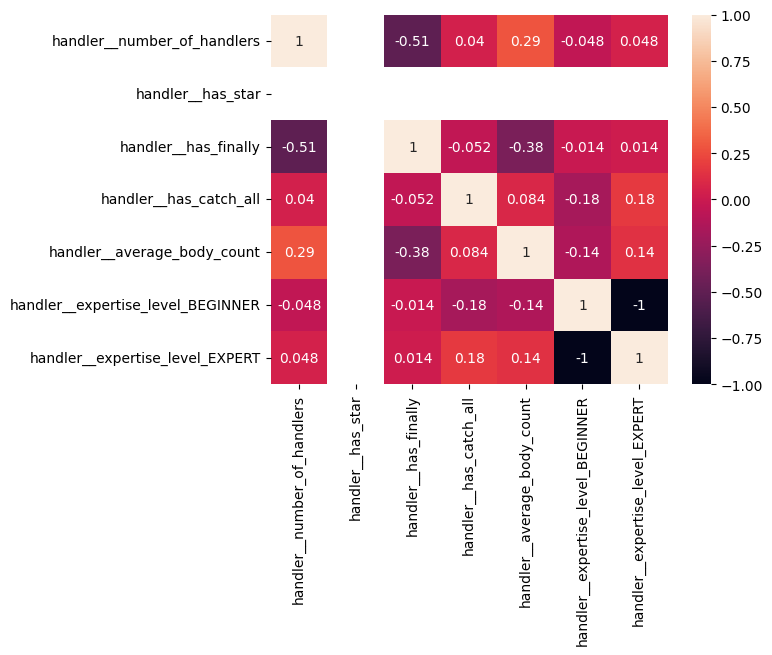

In [10]:
sns.heatmap(X.corr(), annot=True)

## 3 - Detección de valores atípicos (outliers)
## Univariate
## Analisis detallado de variables
Para cada una de las 5 variable (2 numericas y 3 booleanas) se hara un analisis detallado

### Variable number_of_handlers (1/5)
Esta variable es de tipo numérica y nos indica el número de clausulas except en la sentencia Try. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 9. Con una media de 0.99.

<Axes: ylabel='handler__number_of_handlers'>

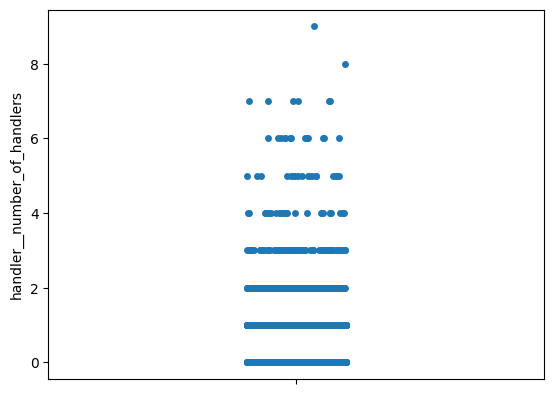

In [11]:
sns.stripplot(X['handler__number_of_handlers'])

In [12]:
print_outliers_for_df_column(X, 'handler__number_of_handlers')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.3888888888888889
Rango valores atípicos extremos (Tukey): [1.0,1.0]
Rango valores atípicos leves (Tukey): [1.0,1.0]
Rango valores atípicos extremos (Fixed BoxPlot): [1.0,1.0]
-3.0IQR: 849 instancias tienen un valor para handler__number_of_handlers inferior a 1.0 (Q1-3*IQR) para handler__number_of_handlers. Representando un 7.859% del total de instancias.
-1.5IQR: 849 instancias tienen un valor para handler__number_of_handlers inferior a 1.0 (Q1-1.5*IQR) para handler__number_of_handlers. Representando un 7.859% del total de instancias.
+1.5IQR: 502 instancias tienen un valor para handler__number_of_handlers superior a 1.0 (Q3+1.5*IQR) para handler__number_of_handlers. Representando un 4.647% del total de instancias.
+3.0IQR: 502 instancias tienen un valor para handler__number_of_handlers superior a 1.0 (Q3-3*IQR) para handler__number_of_handlers. Representando un 4.647% del total de instancias.
L: 849 instancias tienen un valor

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 1 o menor que 1 (Todos los umbrales son 1)

In [13]:
X[(X['handler__number_of_handlers'] > 1) | (X['handler__number_of_handlers'] < 1)].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,handler__number_of_handlers,handler__has_star,handler__has_finally,handler__has_catch_all,handler__average_body_count,handler__expertise_level_BEGINNER,handler__expertise_level_EXPERT
count,1351.000000,1351.0,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000
mean,0.951147,0.0,0.647668,0.028127,0.579844,0.824574,0.175426
std,1.415464,0.0,0.477874,0.165398,0.941027,0.380472,0.380472
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000
75%,2.000000,0.0,1.000000,0.000000,1.000000,1.000000,0.000000
max,9.000000,0.0,1.000000,1.000000,9.000000,1.000000,1.000000


### Variable average_body_count (2/5)
Esta variable representa el número medio de sentencias en los cuerpos del try y los except. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 0. Con una media de 1.28.

<Axes: ylabel='handler__average_body_count'>

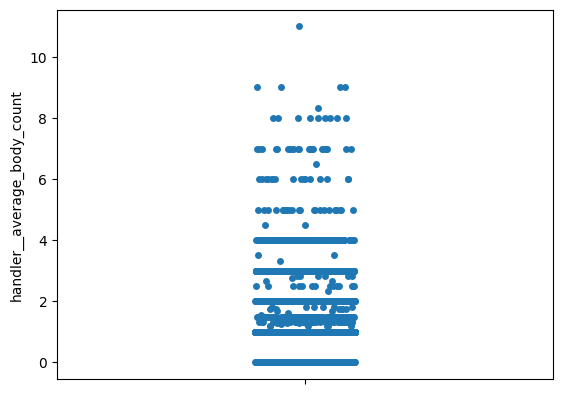

In [14]:
sns.stripplot(X['handler__average_body_count'])

In [15]:
print_outliers_for_df_column(X, 'handler__average_body_count')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.8936579475688159
Rango valores atípicos extremos (Tukey): [1.0,1.0]
Rango valores atípicos leves (Tukey): [1.0,1.0]
Rango valores atípicos extremos (Fixed BoxPlot): [1.0,1.0]
-3.0IQR: 849 instancias tienen un valor para handler__average_body_count inferior a 1.0 (Q1-3*IQR) para handler__average_body_count. Representando un 7.859% del total de instancias.
-1.5IQR: 849 instancias tienen un valor para handler__average_body_count inferior a 1.0 (Q1-1.5*IQR) para handler__average_body_count. Representando un 7.859% del total de instancias.
+1.5IQR: 2601 instancias tienen un valor para handler__average_body_count superior a 1.0 (Q3+1.5*IQR) para handler__average_body_count. Representando un 24.08% del total de instancias.
+3.0IQR: 2601 instancias tienen un valor para handler__average_body_count superior a 1.0 (Q3-3*IQR) para handler__average_body_count. Representando un 24.08% del total de instancias.
L: 849 instancias tienen un val

In [16]:
X[(X['handler__average_body_count'] > 1) | (X['handler__average_body_count'] < 1)].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,handler__number_of_handlers,handler__has_star,handler__has_finally,handler__has_catch_all,handler__average_body_count,handler__expertise_level_BEGINNER,handler__expertise_level_EXPERT
count,3450.000000,3450.0,3450.000000,3450.000000,3450.000000,3450.000000,3450.000000
mean,0.893623,0.0,0.264348,0.070435,1.812281,0.792174,0.207826
std,0.788795,0.0,0.441049,0.255915,1.333343,0.405810,0.405810
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.0,0.000000,0.000000,1.333333,1.000000,0.000000
50%,1.000000,0.0,0.000000,0.000000,2.000000,1.000000,0.000000
75%,1.000000,0.0,1.000000,0.000000,2.000000,1.000000,0.000000
max,9.000000,0.0,1.000000,1.000000,11.000000,1.000000,1.000000


Puede parecer imposible que haya algun handler con 0 como average body count. Esto se debe a que en Python debido a la indentacion no se permite hacer:
try:
    ...
except:

a = 1 (fuera del except)

Que estos valores sean posibles es debido a la presencia de try con unicamente una cláusula finally.

### Variable has_star (3/5)
Esta variable es de tipo booleano y representa es una sentencia del tipo TryStar.

<Axes: xlabel='handler__has_star', ylabel='Count'>

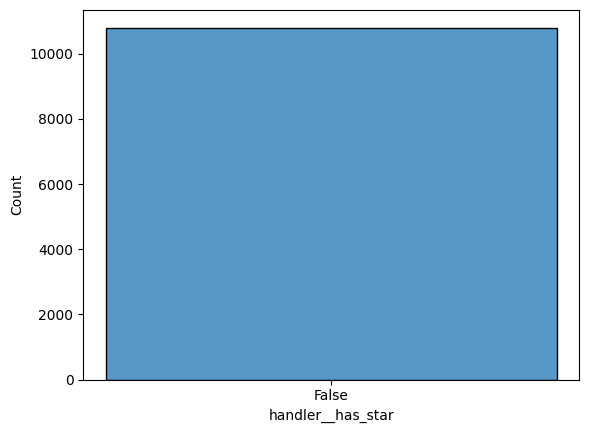

In [17]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['handler__has_star'], discrete=True)

In [18]:
num_true_values = len(X[X['handler__has_star'] == True])
num_false_values = len(X[X['handler__has_star'] == False])
std = X['handler__has_star'].std()
freq_true = len(X[X['handler__has_star'] == True]) / len(X['handler__has_star'])
freq_false = len(X[X['handler__has_star'] == False]) / len(X['handler__has_star'])
print(f'La variable has_star contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_star a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_star a False es {freq_false}.')

La variable has_star contiene 0 valores verdaderos y 10803 valores falsos. Y, la desviación típica es de 0.0
La frecuencia con la que programa puede tener la variable has_star a True es 0.0.
La frecuencia con la que programa puede tener la variable has_star a False es 1.0.


In [19]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'handler__has_star', possible_values)

La variable handler__has_star contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable handler__has_star toma el valor de 0.0 en un 100.0% de los items.
La variable handler__has_star toma el valor de True en un 0.0% de los items. [OUTLIER]


### IMPORTANTE 

No hay ningun try del tipo TryStar por lo que ninguna entrada toma el valor True para has_star

### Variable has_catch_all (4/5)
Esta variable es de tipo booleano y representa si el try tiene un except all.

<Axes: xlabel='handler__has_catch_all', ylabel='Count'>

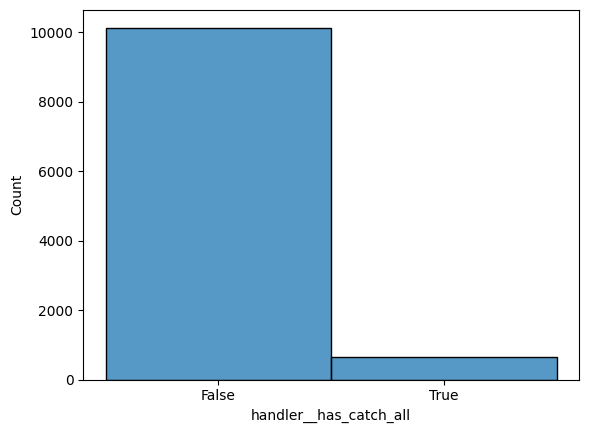

In [20]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['handler__has_catch_all'], discrete=True)

In [21]:
num_true_values = len(X[X['handler__has_catch_all'] == True])
num_false_values = len(X[X['handler__has_catch_all'] == False])
std = X['handler__has_catch_all'].std()
freq_true = len(X[X['handler__has_catch_all'] == True]) / len(X['handler__has_catch_all'])
freq_false = len(X[X['handler__has_catch_all'] == False]) / len(X['handler__has_catch_all'])
print(f'La variable has_catch_all contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_catch_all a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_catch_all a False es {freq_false}.')

La variable has_catch_all contiene 664 valores verdaderos y 10139 valores falsos. Y, la desviación típica es de 0.24019132554531097
La frecuencia con la que programa puede tener la variable has_catch_all a True es 0.06146440803480515.
La frecuencia con la que programa puede tener la variable has_catch_all a False es 0.9385355919651949.


In [22]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'handler__has_catch_all', possible_values)

La variable handler__has_catch_all contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable handler__has_catch_all toma el valor de 0.0 en un 93.85% de los items.
La variable handler__has_catch_all toma el valor de 1.0 en un 6.146% de los items.


In [23]:
X[X['handler__has_catch_all'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])


,handler__number_of_handlers,handler__has_star,handler__has_finally,handler__has_catch_all,handler__average_body_count,handler__expertise_level_BEGINNER,handler__expertise_level_EXPERT
count,664.000000,664.0,664.000000,664.0,664.000000,664.000000,664.000000
mean,1.072289,0.0,0.033133,1.0,1.535015,0.569277,0.430723
std,0.377597,0.0,0.179118,0.0,0.959000,0.495551,0.495551
min,1.000000,0.0,0.000000,1.0,1.000000,0.000000,0.000000
25%,1.000000,0.0,0.000000,1.0,1.000000,0.000000,0.000000
50%,1.000000,0.0,0.000000,1.0,1.000000,1.000000,0.000000
75%,1.000000,0.0,0.000000,1.0,2.000000,1.000000,1.000000
max,8.000000,0.0,1.000000,1.0,9.000000,1.000000,1.000000


### Variable has_finally (5/5)
Esta variable es de tipo booleano y representa si el Try tiene la clausula finally.

<Axes: xlabel='handler__has_finally', ylabel='Count'>

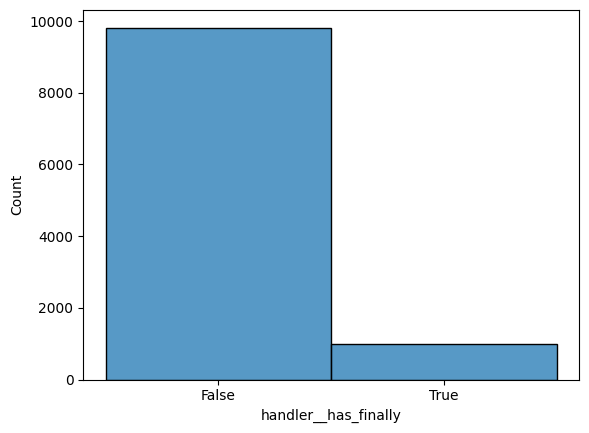

In [24]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['handler__has_finally'], discrete=True)

In [25]:
num_true_values = len(X[X['handler__has_finally'] == True])
num_false_values = len(X[X['handler__has_finally'] == False])
std = X['handler__has_finally'].std()
freq_true = len(X[X['handler__has_finally'] == True]) / len(X['handler__has_finally'])
freq_false = len(X[X['handler__has_finally'] == False]) / len(X['handler__has_finally'])
print(f'La variable has_finally contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_finally a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_finally a False es {freq_false}.')

La variable has_finally contiene 985 valores verdaderos y 9818 valores falsos. Y, la desviación típica es de 0.2878759503364563
La frecuencia con la que programa puede tener la variable has_finally a True es 0.09117837637693234.
La frecuencia con la que programa puede tener la variable has_finally a False es 0.9088216236230676.


In [26]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'handler__has_finally', possible_values)

La variable handler__has_finally contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable handler__has_finally toma el valor de 0.0 en un 90.88% de los items.
La variable handler__has_finally toma el valor de 1.0 en un 9.118% de los items.


In [27]:
X[X['handler__has_finally'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,handler__number_of_handlers,handler__has_star,handler__has_finally,handler__has_catch_all,handler__average_body_count,handler__expertise_level_BEGINNER,handler__expertise_level_EXPERT
count,985.000000,985.0,985.0,985.000000,985.000000,985.000000,985.000000
mean,0.188832,0.0,1.0,0.022335,0.255854,0.812183,0.187817
std,0.593732,0.0,0.0,0.147846,0.779587,0.390765,0.390765
min,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,1.0,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.0,1.0,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.0,1.0,0.000000,0.000000,1.000000,0.000000
max,8.000000,0.0,1.0,1.000000,8.333333,1.000000,1.000000


## Multivariate

TODO: isolation forest algorithm

In [28]:
from sklearn.ensemble import  IsolationForest

CONTAMINATION_FACTOR = 0.0012

isof_model = IsolationForest(contamination=CONTAMINATION_FACTOR, random_state=0)
isof_prediction = isof_model.fit_predict(X.to_numpy())
mask = isof_prediction == -1
multivar_outliers = X[mask].index.tolist()
full_table.iloc[multivar_outliers]

,handler__number_of_handlers,handler__has_finally,handler__has_catch_all,handler__average_body_count,handler__has_star,handler__expertise_level
93,6,True,False,2.833333,False,BEGINNER
9266,3,False,False,9.000000,False,EXPERT
9317,3,True,False,8.333333,False,EXPERT
9319,3,True,True,2.000000,False,EXPERT
9328,2,False,True,4.500000,False,EXPERT
9416,2,True,True,1.000000,False,EXPERT
9485,5,True,False,1.600000,False,EXPERT
9662,3,True,False,5.000000,False,EXPERT
9727,2,True,True,1.000000,False,EXPERT
9728,1,False,True,9.000000,False,EXPERT


### IMPORTANTE
Hay que analizar los 13 outliers detectados